In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sun Dec 20 21:39:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   39C    P8    24W / 250W |   2333MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   79C    P0    95W / 250W |   7838MiB / 16280MiB |     95%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_19November20 import All_CNN6Layer_A as ModelA
from model.models_mjp_19November20 import All_CNN6Layer_E as ModelE
from model.models_mjp_19November20 import All_CNN8Layer_W as ModelW

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(2)

1 available GPUs (initially using device 0):
  0 TITAN V


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 40, 5e-5, 1420)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 12.7 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 12.21 s
Constructing 160000 event dataset took 4.378 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 3.169 s
Constructing 9984 event dataset took 0.1182 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelW()

#summary(model.to(device), (1, 4000))

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('ALLCNN')

In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=5.0)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/12/8b785a70654248ef9adc836faf9afb2c/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict)

we also froze 0 weights
Of the 8.0 parameter layers to update in the current model, 8.0 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

All_CNN8Layer_W(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(20, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (conv6dropout): Dropout(p=0.15, inplace=False)
  (conv7dropout): Dropout(p=0.15, inplace=False)
)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


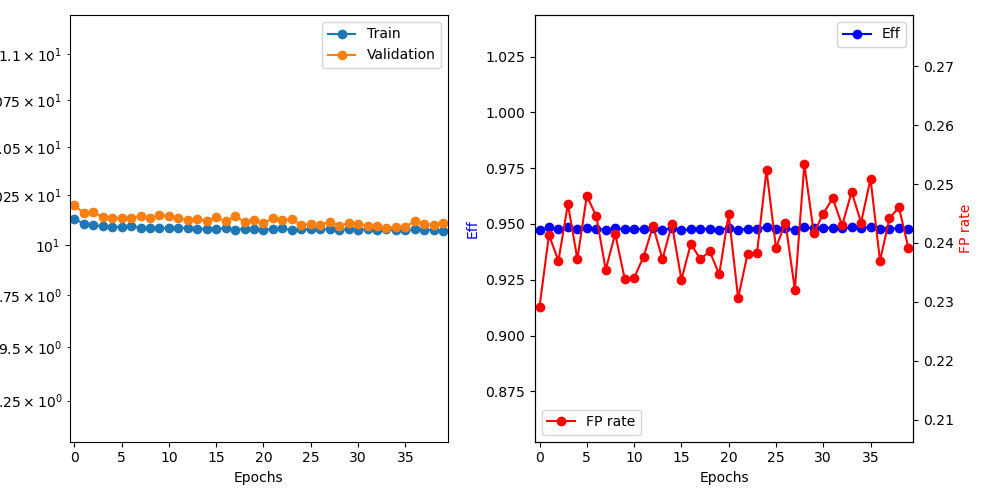

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

for model:  All_CNN8Layer_W(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(20, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (conv6dropout): Dropout(p=0.15, inplace=False)
  (conv7dropout): Dropout(p=0.15, inplace=False)
)
epoch_start 1420
batch_size 128
epochs 40
lr 5e

/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 1420: train=10.1321, val=10.1986, took 47.833 s
  Validation Found 51625 of 54504, added 2288 (eff 94.72%) (0.229 FP/event)
Result epoch:  1420
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1421: train=10.1044, val=10.1599, took 47.49 s
  Validation Found 51694 of 54504, added 2410 (eff 94.84%) (0.241 FP/event)
Result epoch:  1421
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1422: train=10.0981, val=10.1637, took 47.507 s
  Validation Found 51653 of 54504, added 2366 (eff 94.77%) (0.237 FP/event)
Result epoch:  1422
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1423: train=10.093, val=10.14, took 47.488 s
  Validation Found 51698 of 54504, added 2462 (eff 94.85%) (0.247 FP/event)
Result epoch:  1423
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1424: train=10.0889, val=10.1373, took 47.483 s
  Validation Found 51659 of 54504, added 2369 (eff 94.78%) (0.237 FP/event)
Result epoch:  1424
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1425: train=10.0897, val=10.1338, took 47.486 s
  Validation Found 51690 of 54504, added 2476 (eff 94.84%) (0.248 FP/event)
Result epoch:  1425
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1426: train=10.0934, val=10.1358, took 47.512 s
  Validation Found 51656 of 54504, added 2442 (eff 94.77%) (0.245 FP/event)
Result epoch:  1426
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1427: train=10.0847, val=10.1426, took 47.41 s
  Validation Found 51640 of 54504, added 2351 (eff 94.75%) (0.235 FP/event)
Result epoch:  1427
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1428: train=10.0843, val=10.1325, took 47.364 s
  Validation Found 51670 of 54504, added 2412 (eff 94.80%) (0.242 FP/event)
Result epoch:  1428
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1429: train=10.0857, val=10.1486, took 47.382 s
  Validation Found 51652 of 54504, added 2336 (eff 94.77%) (0.234 FP/event)
Result epoch:  1429
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1430: train=10.0837, val=10.1431, took 47.517 s
  Validation Found 51650 of 54504, added 2337 (eff 94.76%) (0.234 FP/event)
Result epoch:  1430
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1431: train=10.0852, val=10.1343, took 47.454 s
  Validation Found 51663 of 54504, added 2373 (eff 94.79%) (0.238 FP/event)
Result epoch:  1431
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1432: train=10.0844, val=10.124, took 47.495 s
  Validation Found 51683 of 54504, added 2425 (eff 94.82%) (0.243 FP/event)
Result epoch:  1432
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1433: train=10.0803, val=10.1293, took 47.735 s
  Validation Found 51642 of 54504, added 2369 (eff 94.75%) (0.237 FP/event)
Result epoch:  1433
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1434: train=10.0796, val=10.1201, took 47.66 s
  Validation Found 51675 of 54504, added 2428 (eff 94.81%) (0.243 FP/event)
Result epoch:  1434
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1435: train=10.0798, val=10.1382, took 47.096 s
  Validation Found 51623 of 54504, added 2334 (eff 94.71%) (0.234 FP/event)
Result epoch:  1435
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1436: train=10.0818, val=10.1177, took 71.28 s
  Validation Found 51648 of 54504, added 2395 (eff 94.76%) (0.24 FP/event)
Result epoch:  1436
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1437: train=10.0762, val=10.1431, took 95.08 s
  Validation Found 51649 of 54504, added 2369 (eff 94.76%) (0.237 FP/event)
Result epoch:  1437
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1438: train=10.0796, val=10.1165, took 97.249 s
  Validation Found 51657 of 54504, added 2382 (eff 94.78%) (0.239 FP/event)
Result epoch:  1438
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1439: train=10.0792, val=10.1228, took 98.997 s
  Validation Found 51638 of 54504, added 2343 (eff 94.74%) (0.235 FP/event)
Result epoch:  1439
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1440: train=10.0754, val=10.1097, took 98.826 s
  Validation Found 51679 of 54504, added 2445 (eff 94.82%) (0.245 FP/event)
Result epoch:  1440
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1441: train=10.0786, val=10.1331, took 99.113 s
  Validation Found 51624 of 54504, added 2303 (eff 94.72%) (0.231 FP/event)
Result epoch:  1441
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1442: train=10.083, val=10.1245, took 98.348 s
  Validation Found 51668 of 54504, added 2378 (eff 94.80%) (0.238 FP/event)
Result epoch:  1442
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1443: train=10.0738, val=10.1275, took 98.806 s
  Validation Found 51658 of 54504, added 2380 (eff 94.78%) (0.238 FP/event)
Result epoch:  1443
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1444: train=10.0775, val=10.1005, took 98.948 s
  Validation Found 51712 of 54504, added 2520 (eff 94.88%) (0.252 FP/event)
Result epoch:  1444
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1445: train=10.0766, val=10.1028, took 98.163 s
  Validation Found 51656 of 54504, added 2388 (eff 94.77%) (0.239 FP/event)
Result epoch:  1445
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1446: train=10.0776, val=10.0993, took 99.056 s
  Validation Found 51671 of 54504, added 2431 (eff 94.80%) (0.243 FP/event)
Result epoch:  1446
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1447: train=10.0804, val=10.1155, took 98.685 s
  Validation Found 51630 of 54504, added 2317 (eff 94.73%) (0.232 FP/event)
Result epoch:  1447
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1448: train=10.0746, val=10.0961, took 98.005 s
  Validation Found 51703 of 54504, added 2530 (eff 94.86%) (0.253 FP/event)
Result epoch:  1448
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1449: train=10.0766, val=10.1088, took 98.826 s
  Validation Found 51670 of 54504, added 2413 (eff 94.80%) (0.242 FP/event)
Result epoch:  1449
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 1450: train=10.0757, val=10.1036, took 98.971 s
  Validation Found 51685 of 54504, added 2446 (eff 94.83%) (0.245 FP/event)
Result epoch:  1450
Average Eff:  0.9482790253926318
Average FP Rate:  0.24496745117676516


Epoch 1451: train=10.0785, val=10.0941, took 98.507 s
  Validation Found 51683 of 54504, added 2472 (eff 94.82%) (0.248 FP/event)
Result epoch:  1451
Average Eff:  1.8965213562307355
Average FP Rate:  0.4925388082123185


Epoch 1452: train=10.0758, val=10.0937, took 98.651 s
  Validation Found 51672 of 54504, added 2426 (eff 94.80%) (0.243 FP/event)
Result epoch:  1452
Average Eff:  2.8445618670189345
Average FP Rate:  0.7355032548823235


Epoch 1453: train=10.0767, val=10.0848, took 98.793 s
  Validation Found 51694 of 54504, added 2483 (eff 94.84%) (0.249 FP/event)
Result epoch:  1453
Average Eff:  3.7930060179069427
Average FP Rate:  0.9841762643965949


Epoch 1454: train=10.072, val=10.091, took 97.981 s
  Validation Found 51692 of 54504, added 2431 (eff 94.84%) (0.243 FP/event)
Result epoch:  1454
Average Eff:  4.741413474240423
Average FP Rate:  1.2276414621932898


Epoch 1455: train=10.072, val=10.0897, took 98.799 s
  Validation Found 51697 of 54504, added 2505 (eff 94.85%) (0.251 FP/event)
Result epoch:  1455
Average Eff:  5.689912666960223
Average FP Rate:  1.4785177766649973


Epoch 1456: train=10.0766, val=10.1195, took 97.056 s
  Validation Found 51655 of 54504, added 2366 (eff 94.77%) (0.237 FP/event)
Result epoch:  1456
Average Eff:  6.637641274034933
Average FP Rate:  1.7154732098147218


Epoch 1457: train=10.0742, val=10.1038, took 98.505 s
  Validation Found 51668 of 54504, added 2438 (eff 94.80%) (0.244 FP/event)
Result epoch:  1457
Average Eff:  7.585608395714075
Average FP Rate:  1.959639459188783


Epoch 1458: train=10.0736, val=10.1016, took 99.13 s
  Validation Found 51671 of 54504, added 2457 (eff 94.80%) (0.246 FP/event)
Result epoch:  1458
Average Eff:  8.53363055922501
Average FP Rate:  2.2057085628442663


Epoch 1459: train=10.068, val=10.1101, took 98.654 s
  Validation Found 51659 of 54504, added 2388 (eff 94.78%) (0.239 FP/event)
Result epoch:  1459
Averaging...

Average Eff:  0.9481432555408776
Average FP Rate:  0.2444867300951427



<IPython.core.display.Javascript object>


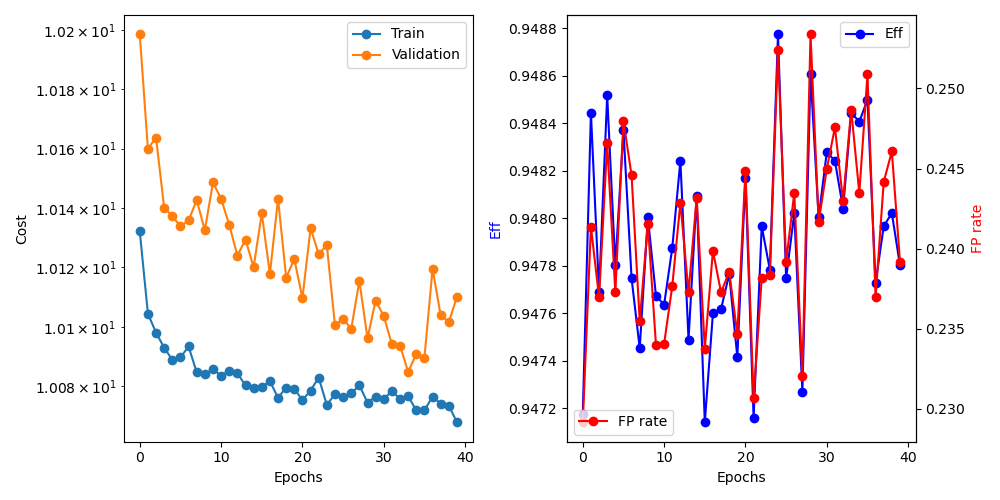

In [12]:
avgEff = 0.0
avgFP = 0.0
print('for model: ', model)   
run_name = 'ACNN W Avg.'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
    
        xs = results.index
    
        # Update the plot above
        lines['train'].set_data(results.index,results.cost)
        lines['val'].set_data(results.index,results.val)
    
        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
        
        print('Result epoch: ', result['epoch'])
        if(result['epoch'] >= args.epochs + args.epoch_start - 10):
            avgEff += result['eff_val'].eff_rate
            avgFP += result['eff_val'].fp_rate
           
        if(result['epoch'] == args.epochs + args.epoch_start - 1):
            print('Averaging...\n')
            avgEff /= 10
            avgFP /= 10
            mlflow.log_metric('10 Efficiency Average', avgEff)
            mlflow.log_metric('10 False Positive Average', avgFP)
            
        print('Average Eff: ', avgEff)
        print('Average FP Rate: ', avgFP)
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Asymmetry', '5.0')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
            
        # Save a diagram of the architecture
#        HL.transforms.Fold("Conv", "Conv"),
#        HL.build_graph(model, torch.zeros([args.batch_size, 1, 4000]).to(device)).save('architecture', format='png')
#        mlflow.log_artifact('architecture.png')
        
        # log the code for the model architecture
#        mlflow.log_artifact('architecture.txt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    # save plot
    plt.tight_layout()
    plt.savefig('plot.png')
    mlflow.log_artifact('plot.png')

In [13]:
##quit()